In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import nice_layers as vnn
import torchvision
from imp import reload

In [103]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [109]:
reload(vnn)
nonneg = True
model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=2, nonneg=False, first_layer=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=2, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=1, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 1536, 1, nonneg=nonneg))

data = torch.randn(10, 3, 32, 32)
input = vnn.expand_input_conv(data, 10)
out = model(input)

A
B
B
Instantiated t with shape (10, 96, 14, 14)
Instantiated t with shape (10, 96, 6, 6)
Instantiated t with shape (10, 96, 4, 4)


(array([ 1.,  1.,  3., 14., 22., 30., 18.,  8.,  2.,  1.]),
 array([-0.6666694 , -0.53852534, -0.41038126, -0.2822372 , -0.15409312,
        -0.02594903,  0.10219505,  0.23033912,  0.3584832 ,  0.48662728,
         0.61477137], dtype=float32),
 <BarContainer object of 10 artists>)

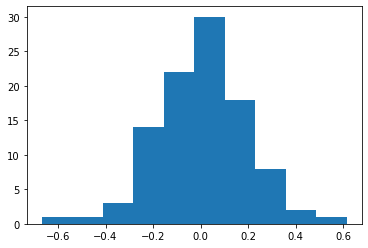

In [105]:
vals = out.detach().numpy().flatten()
plt.hist(vals)

In [110]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = vnn.expand_input_conv(data, 10)
        out = model(input)[..., 0]
        loss = loss_fn(out, labels)
        epoch_loss += loss.item()
        epoch_correct += (out.argmax(dim=1) == labels).float().sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 50000.)

0


KeyboardInterrupt: 

In [102]:
a[:10]

array([-0.4066406 ,  0.4066406 , -0.5700387 ,  0.5700387 ,  0.46114367,
       -0.46114367,  0.        , -0.        , -0.        ,  0.        ],
      dtype=float32)